# Notebooks in ArcGIS Pro

The integration of ArcGIS Notebooks directly within the ArcGIS Pro user interface was added as a new feature in ArcGIS Pro 2.5, released in February, 2020.  It provides all of the same core functionality as a standard Jupyter Notebook server, with some additional capabilities that come from running within the same Python environment that underlies the ArcGIS Pro's geoprocessing framework:

* Geometry data objects can be visualized directly in a code cell's output when a notebook is running within ArcGIS Pro.
* Layers in an active map or scene view in the current ArcGIS Pro project can be accessed by name, instead referencing a path to a dataset.
* New layers created as output from executing geoprocessing tools in a notebook can be automatically added to an active map or scene view in the current ArcGIS Pro project.

Following best practices in Python, you will begin this notebook by importing the modules that you will be using.  The `arcpy` does not need to be imported when a notebook is running inside of ArcGIS Pro, though it doesn't hurt to included anyway:

In [1]:
import arcpy
from arcgis.gis import GIS
from pprint import pprint

To ensure the default behaviour in ArcGIS Pro to automatically add geoprocessing outputs to an active map or scene is enabled, and to ensure you are allowed to overwrite existing outputs, the following properties of the `arcpy.env` module may be set to `True`:

In [2]:
arcpy.env.addOutputsToMap = True
arcpy.env.overwriteOutput = True

## Previewing geometries

When working with data in ArcPy, you may often find yourself operating with [Geometry](https://pro.arcgis.com/en/pro-app/arcpy/classes/geometry.htm) objects for individual features.  Until now, you would need to visualize geometries by selecting them in an existing layer, or writing them to a new feature layer and viewing them in a map view.  However, within a Python notebook in ArcGIS Pro, you can return the geometry on the last line of a code cell, and see a preview of the geometry as an embedded graphic.

As an example, you can use the `arcpy.da` data access module to inspect individual geometries of any layer (e.g., the [World Countries (Generalized)](https://edu.maps.arcgis.com/home/item.html?id=2b93b06dc0dc4e809d3c8db5cb96ba69) from the [ArcGIS Living Atlas of the World](https://livingatlas.arcgis.com/en/)). For feature layers in ArcGIS Online or ArcGIS Enterprise, you can use the URL to an individual layer the same as the file path to a local feature class.  Ensure that `'shape@'` is included in your list of selected field names.

When you have obtained a `Geometry` object, return it on the last line of the cell to see it visualize graphically in the cell's output.

Execute the cell below to see the generalized boundary for Canada, and/or try changing the name of the country in the SearchCursor's where_clause:

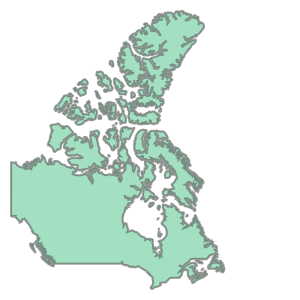

In [8]:
from arcgis.gis import GIS
gis = GIS()
countries = gis.content.get('2b93b06dc0dc4e809d3c8db5cb96ba69')

for row in arcpy.da.SearchCursor(in_table=countries.layers[0].url, 
                                 field_names=["shape@"], 
                                 where_clause="COUNTRY = 'Canada'"):
    geom = row[0]

geom

## Accessing layers in an active Map

1. If you do not currently have Map view open in the Project, add a new one from the 'Insert' toolbar in the main ribbon interface.  You may choose to position the notebook and Map to appear side-by-side in the ArcGIS Pro interface (if your screen is sufficiently large).
1. Open the 'Catalog' pane (if it's not visible, you can access it from the 'View' toolbar in the ribbon interface).  Open the 'Portal' section of the Catalog pane, choose 'All Portal', and enter 'mci 2014 to 2019' in the search intput.  You should discover a layer named 'MCI 2014 to 2019' published by the Toronto Police Service.
1. Right-click on the MCI feature layer and choose 'Add To Current Map'
> Note: if you are unable to find the layer, or do not have a sufficently fast Internet connection, you can access a local copy of the data.  You will need to extract the contents of the `notebook_basics/data/toronto/MCI.gdb.zip` archive into the same location.  Once that is done - in the Project section of the Catalog pane in ArcGIS Pro, you will find this layer under Folders > notebook_basics > data > toronto > MCI.gdb (refresh the folder in the Catalog pane if necessary)

With this layer added to your map, it will become available with the name that appears in the Map's contents (if necessary, open the Contents pane from the 'View' toolbar).  In this case, the name will be 'MCI_2014_to_2019'.

Let's inspect the fields in this layer:

In [3]:
pprint([f.name for f in arcpy.Describe('MCI_2014_to_2019').fields], 
       compact=True, width=60)

['Index_', 'event_unique_id', 'occurrencedate',
 'reporteddate', 'premisetype', 'ucr_code', 'ucr_ext',
 'offence', 'reportedyear', 'reportedmonth', 'reportedday',
 'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
 'occurrenceyear', 'occurrencemonth', 'occurrenceday',
 'occurrencedayofyear', 'occurrencedayofweek',
 'occurrencehour', 'MCI', 'Division', 'Hood_ID',
 'Neighbourhood', 'Long', 'Lat', 'Shape']


You can see in the map view that this layer is not easy to interpret when added as a simple point feature layer, as there are too many data points to visualize effectively.

You can generate a space-time data cube from the point data, which will enable us to analyze and display spatio-temporal patterns in the data using the [Emerging Hot Spot Analysis tool](https://pro.arcgis.com/en/pro-app/tool-reference/space-time-pattern-mining/emerginghotspots.htm).  Typically, it is inefficient to perform local geoprocessing tasks with hosted feature layers, so we'll start by making a local copy (if it is not already extracted to your local files):

In [4]:
if not arcpy.Exists('data/toronto/MCI.gdb'):
    arcpy.management.CreateFileGDB('data/toronto', 'MCI.gdb')

if not arcpy.Exists('data/toronto/MCI.gdb/MCI_2014_to_2019_local'):
    # Copy features from the layer to a local feature class - the result
    # will automatically be added to the map view:
    arcpy.management.CopyFeatures(
        'MCI_2014_to_2019', 
        'data/toronto/MCI.gdb/MCI_2014_to_2019_local'
    )
else:
    # Add the already-existing layer to the current map view:
    aprx = arcpy.mp.ArcGISProject("CURRENT")
    aprx.activeMap.addLayer(
        arcpy.mp.LayerFile('data/toronto/MCI_2014_to_2019_local.lyrx')
    )

Using the local copy of the data, create a spatio-temporal data cube representing the monthly frequency of occurrence of all crimes reported to the Toronto Police Service from 2014 to 2019.

> Note: the occurrence date of crimes is not always consistent with reported dates (e.g., approximately one thousand out of the ~200k reports in the dataset are reports of crimes that occurred prior to 2014).  So you first filter the data to exclude crimes that occurred prior to 2014.

In [5]:
arcpy.management.SelectLayerByAttribute(
    "MCI_2014_to_2019_local", 
    "NEW_SELECTION", 
    "occurrencedate >= timestamp '2014-01-01 00:00:00'", 
    None
)

arcpy.stpm.CreateSpaceTimeCube(
    "MCI_2014_to_2019_local", 
    "data/toronto/MCI_2014_to_2019.nc", 
    "occurrencedate", 
    None, 
    "1 Months", 
    "END_TIME", 
    None, 
    "500 Meters", 
    None, 
    "HEXAGON_GRID", 
    None, 
    None
)

<Result 'data\\toronto\\MCI_2014_to_2019.nc'>

Now that you have a space-time data cube prepared in the resulting NetCDF dataset, you can execute the Emerging Hot Spot Analysis tool:

In [6]:
if arcpy.Exists("data/toronto/MCI.gdb/MCI_hotspots"):
    arcpy.management.Delete("data/toronto/MCI.gdb/MCI_hotspots")
    
arcpy.stpm.EmergingHotSpotAnalysis(
    "data/toronto/MCI_2014_to_2019.nc", 
    "COUNT", 
    "data/toronto/MCI.gdb/MCI_hotspots", 
    None, 
    1, 
    None, 
    "FIXED_DISTANCE", 
    None, 
    "ENTIRE_CUBE"
)

<Result 'data\\toronto\\MCI.gdb\\MCI_hotspots'>

## Layers automatically added to Map View

As noted, layers that are output from executing `arcpy` geoprocessing functionss are automatically added to the map.  After completing the steps above, you will find that layer from the Emerging Hot Spot Analysis tool has been added to the current Map view in ArcGIS Pro.  In order to be able to see the polygons in this layer, you will need to turn off the layers displaying the MCI point features (from the Contents pane).

In the layer that has been added to the map by the emerging hot spot analysis tool, you should see a pattern similar to the graphic below. These results show a distinct pattern of intensifying hotspots and persistent cold spots.  The benefit of having this output automatically added to your map is that the default styling applied to layers produced by geoprocessing tools will be applied.  In the case of the Emerging Hotspot Analysis Tool, you will see different symbols applied to each polygon reflecting 17 different possible values in the `PATTERN` attribute that describes the pattern of hot spots and cold spots throughout the time series of data.

![hotspots.png](images/hotspots.png)

Anyone who is familar with the City of Toronto will recognize that the overall pattern of hot and cold spots in this analysis is consistent with the distribution of population density accross the area.  Thus this result is likely a reflection of the distribution of population density across the city, rather than an indication of whether there are more or less crimes that should be anticipated at any given time or location.

Therefore, further analysis is necessary if you want to understand better where crime rates might actually be intensifyng relative to other areas taking into account local population density.

This analysis will continue in the next notebook, which is configured to work as hosted ArcGIS Notebook in either ArcGIS Online or ArcGIS Enterprise.

To proceed with the next notebook in this series:
1. Login to your ArcGIS Enterprise or ArcGIS Online account (if you have hosted Notebooks enabled)
1. Navigate to your content
1. Choose to add an item from your computer
1. Select the `arcgis_notebooks/notebook_basics/hosted_notebook.ipynb` document, edit the title as desired and enter at least one search tag, then click 'Add Item'.  When you are presented with the new item details page for your uploaded notebook, click the 'Open Notebook' button to begin.
> Note: if you do not have access to hosted Notebooks in ArcGIS Online or ArcGIS Enterprise, you may open your notebook locally with Jupiter Notebook server, but you will need to revise the `GIS()` connection parameters, and manually input code that would otherwise be inserted into the notebook by following the described workflow in an ArcGIS Online or ArcGIS Enterprise environment.